# Development Manuscript Analysis: greedy forward selection
This notebook does the greedy forward selection analysis for all three endpoints to select features for multivariate models to build the regression model (for Gd lesions) and the classification models (for all binary endpoints).

In [1]:
# Package imports...
# Basic:
import os
import sys
import psutil
# Data handling:
import io
import json
import pandas as pd
# Computations:
from datetime import datetime
from time import sleep
import numpy as np
from collections import Counter
# import ray
from scipy.stats import linregress
from sklearn.metrics import roc_auc_score
# Mine:
from modeling import npx_dc_correction, create_model, train_model
# Visualization:
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Object persistance:
import joblib
# Constants...
fig_font   = { "weight": "bold", "size": 12 }
title_font = { "weight": "bold", "size": 16 }
small_font = { "weight": "bold", "size": 8 }
matplotlib.rc( "font", **fig_font )

## Read in the F4, F5, and ACP data.
We're not reading from Domo because this paper is about the relative quantitation data taken in mid 2019 and analyzed in late 2019 through 2020. As such, we are reading archival versions of the protein concentration values that were uplaoded to Athena. Those are currently stored on [google drive](https://drive.google.com/drive/folders/1dYgunVtA0w50oRdW2MS0PDZI18NW5Ba7?usp=sharing).

In [2]:
# Specify the file names for the data tables.
excel_file_names = { "f4": "F4_Intensity_LOD_QC_ExtraOncologyIII-Olink+RBM_Shifts_OCTAVE_CONFIDENTIAL+PROPRIETARY_Log2RBM_3TF.xlsx", \
                     "f5": "F5_EPIC_Intensity_LOD_QC_Olink_OCTAVE_CONFIDENTIAL+PROPRIETARY_3TF.xlsx", \
                    "acp": "ACP_LOD_QC_Olink_OCTAVE_CONFIDENTIAL+PROPRIETARY_Log2RBM_3TF.xlsx" }
# Read in the protein tables.
print( "Reading protien data..." )
read_start = datetime.now()
protein_tables = { study: pd.read_excel( "./protein_data/{:}".format( file_name ), sheet_name = "prot", index_col = "sample.barcode" ) \
                   for study, file_name in excel_file_names.items() }
print( "\t...Finished in", datetime.now() - read_start )
# Same for the clinical tables.
print( "Reading clinical data..." )
read_start = datetime.now()
clinical_tables = { study: pd.read_excel( "./protein_data/{:}".format( file_name ), sheet_name = "clin_analysis", index_col = "sample.barcode" ) \
                    for study, file_name in excel_file_names.items() }
print( "\t...Finished in", datetime.now() - read_start )

Reading protien data...
	...Finished in 0:00:04.043271
Reading clinical data...
	...Finished in 0:00:00.205708


## Extract the LIMS IDs/sample barcodes that correspond to real samples
The logic for this is _a little_ different for different studies, so we're going to handle them separately.

In [3]:
valid_lims_ids = { "f4": sorted( clinical_tables[ "f4" ][ clinical_tables[ "f4" ][ "Patient_Group" ].str.contains( "AIM3" ) ].index ), 
                   "f5": sorted( clinical_tables[ "f5" ][ clinical_tables[ "f5" ][ "Collection_Group" ] == "F5_EPIC" ].index ), \
                  "acp": sorted( clinical_tables[ "acp" ][ ~clinical_tables[ "acp" ][ "Patient_Group" ].str.contains( "_PC" ) ].index ) }

## Bridge normalize the protein data from F5 to match the F4 Redo samples

In [4]:
# Define the list of biomarkers on the CAP...
biomarker_columns = [ "APLP1-Olink METABOLISM",    "CCL20-Olink INFLAMMATION",    "CD6-Olink INFLAMMATION",            "CDCP1-Olink INFLAMMATION",          "COL4A1-Olink CELL REGULATION", \
                      "CNTN2-Olink ORGAN DAMAGE",  "CXCL13-Olink ONCOLOGY II",    "CXCL9-Olink INFLAMMATION",          "FLRT2-Olink NEUROLOGY",             "GH-Olink CARDIOVASCULAR II", \
                      "IL-12B-Olink INFLAMMATION", "MOG-Olink CELL REGULATION",   "NEFL-Olink NEURO EXPLORATORY",      "OPG-Olink INFLAMMATION",            "OPN-Olink CARDIOVASCULAR III", \
                      "PRTG-Olink NEUROLOGY",      "SERPINA9-Olink ORGAN DAMAGE", "TNFRSF10A-Olink CARDIOVASCULAR II", "TNFSF13B-Olink CARDIOVASCULAR III", "VCAN-Olink METABOLISM" ]
# Identify the protein column names in the combined table.
protein_columns = [ bmkr.split( "-Olink" )[ 0 ].lower() for bmkr in biomarker_columns ]
# Isolate thee sample IDs for the redo samples in F5.
bridge_sample_ids = clinical_tables[ "f5" ][ clinical_tables[ "f5" ][ "Collection_Group" ] == "AIM3_F4_redo" ].index
# Perform a linear regression to find the mapping of NPX values from F5 into the scale for F4 for each protein.
bridge_normalization_regr = { prot: linregress( protein_tables[ "f4" ].loc[ bridge_sample_ids ][ protein_tables[ "f4" ].loc[ bridge_sample_ids ][ bmkr ].notna() & \
                                                                                                 protein_tables[ "f5" ].loc[ bridge_sample_ids ][ bmkr ].notna() ][ bmkr ].values, \
                                                protein_tables[ "f5" ].loc[ bridge_sample_ids ][ protein_tables[ "f4" ].loc[ bridge_sample_ids ][ bmkr ].notna() & \
                                                                                                 protein_tables[ "f5" ].loc[ bridge_sample_ids ][ bmkr ].notna() ][ bmkr ].values ) \
                              for prot, bmkr in zip( protein_columns, biomarker_columns ) }
# Now create the adjusted NPX values for F5.
bridge_normalized_npx = { prot: ( protein_tables[ "f5" ].loc[ valid_lims_ids[ "f5" ] ][ bmkr ] * bridge_normalization_regr[ prot ].slope ) + bridge_normalization_regr[ prot ].intercept \
                          for prot, bmkr in zip( protein_columns, biomarker_columns ) }
# Finally, update the salient values in the F5 study.
for prot, bmkr in zip( protein_columns, biomarker_columns ):
    for lims_id in valid_lims_ids[ "f5" ]:
        protein_tables[ "f5" ].at[ lims_id, bmkr ] = bridge_normalized_npx[ prot ].loc[ lims_id ]

## Pull the clinical columns we're going to need.

In [5]:
 # Now, add the sample ID and protein columns to the combined table, and use the sample ID as the index value.
combined_tables = { study: pd.DataFrame( { bmkr.split( "-Olink" )[ 0 ].lower(): protein_tables[ study ].loc[ valid_lims_ids[ study ] ][ bmkr ].values.astype( np.float64 ) \
                                           for bmkr in biomarker_columns }, \
                                         index = valid_lims_ids[ study ] ) \
                    for study, lims_ids in valid_lims_ids.items() } 
# Set the clinical columns we are keeping for each study.
clinical_columns = { "f4": [ "Brain_Lesions", "Age", "Sex", "DiseaseDuration", "Delta_BloodMinusDiagnosis", "ARR" ], \
                     "f5": [ "Brain_Lesions", "Age", "Sex", "DiseaseDuration", "Delta_BloodMinusDiagnosis" ], \
                    "acp": [ "Label", "Age", "Sex", "DiseaseDuration" ] }
# Now iterate through the studies and the clinical tables associated with each, and add them into the combined table.
# Iterate over the studies...
for study, lims_ids in valid_lims_ids.items():
    # ...and over the clinical columns...
    for clin_col in clinical_columns[ study ]:
        combined_tables[ study ][ clin_col.lower().replace( "sedu", "se_du" ).replace( "odmi", "od_mi" ).replace( "usdi", "us_di") ] = \
                clinical_tables[ study ].loc[ lims_ids ][ clin_col ].values.astype( np.float64 )

## Demographic/clinical corrections.

In [6]:
# Now get ready to run this function. Split out the protein columns...
combined_protein_data = { study: combined_tables[ study ][ protein_columns ] \
                          for study in combined_tables.keys() }
# ...and the clinical ones.
combined_clinical_data = { study: combined_tables[ study ][ [ "age", "sex", "disease_duration" ] ]
                           for study in combined_tables.keys() }
# ...add an endpoint column as the brain lesion count clipped at 0 and 1 (to make it the binarized general disease activity) to the combined clinical table for F4 and F5.
for study in [ "f4", "f5" ]:
    combined_clinical_data[ study ] = combined_clinical_data[ study ].assign( endpoint = combined_tables[ study ][ "brain_lesions" ].clip( 0., 1. ).values )
# ...and add in the clinical endpoint for ACP:
combined_clinical_data[ "acp" ] = combined_clinical_data[ "acp" ].assign( endpoint = combined_tables[ "acp" ][ "label" ] )
# Run the function.
dc_corrected_protein_data, dc_correction_models = {}, {}
for study in combined_clinical_data.keys():
    dc_corrected_protein_data[ study ], dc_correction_models[ study ] = npx_dc_correction( combined_protein_data[ study ], \
                                                                                          combined_clinical_data[ study ], \
                                                                                           holdout_non_npx_columns = [ "endpoint" ], \
                                                                                                    train_col_name = "endpoint", \
                                                                                                     log_transform = False, \
                                                                                                 train_on_neg_samp = True, \
                                                                                                       outlier_pct = 5., \
                                                                                                           verbose = False )
# Since we want the option of including them as covariates, let's also add age, sex, disease duration to the DC corrected data set.
# for study in combined_clinical_data.keys():
#     dc_corrected_protein_data[ study ] = dc_corrected_protein_data[ study ].assign(              age = combined_tables[ study ][ "age"              ].values )
#     dc_corrected_protein_data[ study ] = dc_corrected_protein_data[ study ].assign(              sex = combined_tables[ study ][ "sex"              ].values )
#     dc_corrected_protein_data[ study ] = dc_corrected_protein_data[ study ].assign( disease_duration = combined_tables[ study ][ "disease_duration" ].values )

## Construct feature matricies and label vectors for all three endpoints.
* Gd lesions (Gd) uses F4 and F5
* Clinical relapse status (CRS) uses ACP
* Annualized relapse rate (ARR) uses F4

In [7]:
# Initialize dictionaries to hold the pandas data frame for the features and the series for the labels.
feature_data, labels = {}, {}
# Construct the feature data frame for Gd lesions. It's a concatenation of F4 and F5.
feature_data[ "gd" ] = pd.concat( [ dc_corrected_protein_data[ "f4" ][ combined_tables[ "f4" ][ "delta_blood_minus_diagnosis" ].abs() < 30. ], \
                                    dc_corrected_protein_data[ "f5" ][ combined_tables[ "f5" ][ "delta_blood_minus_diagnosis" ].abs() < 30. ] ], \
                                  axis = 0, ignore_index = False )
# ...and now the label series.
labels[ "gd" ] = pd.concat( [ combined_tables[ "f4" ][ combined_tables[ "f4" ][ "delta_blood_minus_diagnosis" ].abs() < 30. ], \
                              combined_tables[ "f5" ][ combined_tables[ "f5" ][ "delta_blood_minus_diagnosis" ].abs() < 30. ] ], \
                            axis = 0, ignore_index = False )[ "brain_lesions" ]
# Now make sure that the features and labels are _explicitly_ indexed in the same order--not sure if this is strictly necessary, 
# but I can imagine it removing some potential obsticles later.
feature_data[ "gd" ] = feature_data[ "gd" ].loc[ labels[ "gd" ].index ]
# Now, do clinical relapse status. It's _just_ ACP.
feature_data[ "crs" ] = dc_corrected_protein_data[ "acp" ]
labels[ "crs" ] = combined_tables[ "acp" ][ "label" ]
feature_data[ "crs" ] = feature_data[ "crs" ].loc[ labels[ "crs" ].index ]
# Finally, do annualized relapse rate. It's _just_ F4. 
feature_data[ "arr" ] = dc_corrected_protein_data[ "f4" ]
# Remember that we need to binarize ARR with threshold filters.
arr_lo, arr_hi = 0.2, 1.
labels[ "arr" ] = pd.Series( [ 0. if combined_tables[ "f4" ].loc[ ind ][ "arr" ] <  arr_lo else \
                               1. if combined_tables[ "f4" ].loc[ ind ][ "arr" ] >= arr_hi else \
                               np.nan \
                               for ind in dc_corrected_protein_data[ "f4" ].index ], \
                             index = dc_corrected_protein_data[ "f4" ].index )
# Down-select the ARR features to only those with non-nan labels.
arr_to_keep = labels[ "arr" ][ labels[ "arr" ].notna() ].index
feature_data[ "arr" ] = feature_data[ "arr" ].loc[ arr_to_keep ]
labels[       "arr" ] = labels[       "arr" ].loc[ arr_to_keep ]

## Construct train/test splits for each endpoint.
We're going to do an ensemble of bootstraps, where each one trains on 67% of the data and tests on 33%. I haven't decided exactly how many bootstraps to do, but I'll probably debug with a few dozen and finalize this business with 10,000 or so.

In [8]:
# Set the number of bootstraps to do.
n_bootstraps = 1000
# Fraction of the data set on which we're going to train.
training_frac = 0.67
# Set the minimum class membership.
min_class_count = 3
# Initialize a dictionary to hold all the splits for each endpoint.
train_splits, test_splits = { endpoint: [] for endpoint in labels.keys() }, \
                            { endpoint: [] for endpoint in labels.keys() }
# Iterate over the endpoints.
for endpoint in labels.keys():
    # Calculate the size of the training splits
    train_size = int( labels[ endpoint ].size * training_frac )
    # Keep adding splits until we get enough!
    while ( ( len( train_splits[ endpoint ] ) < n_bootstraps ) & \
            ( len(  test_splits[ endpoint ] ) < n_bootstraps ) ):
        # Generate a proposed train split.
        this_train = np.random.choice( labels[ endpoint ].index, \
                                       size = train_size, \
                                    replace = False )
        # Dump the rest of the indecies into the proposed test split.
        this_test = np.array( [ ind for ind in labels[ endpoint ].index \
                                if ind not in this_train ] )
        # Make sure that the label series for each split isn't monolithic.
        if ( ( np.count_nonzero( labels[ endpoint ].loc[ this_train ] ) > min_class_count ) & \
             ( np.count_nonzero( labels[ endpoint ].loc[ this_test  ] ) > min_class_count ) ):
            # ...and if it is, add it to the list.
            train_splits[ endpoint ].append( this_train )
            test_splits[  endpoint ].append( this_test  )
        #...I guess a little stratification is better than none at all...

I've been having a little problem with the class imbalance in the ARR endpoint. Let's look at the distribution of labels across all the splits.

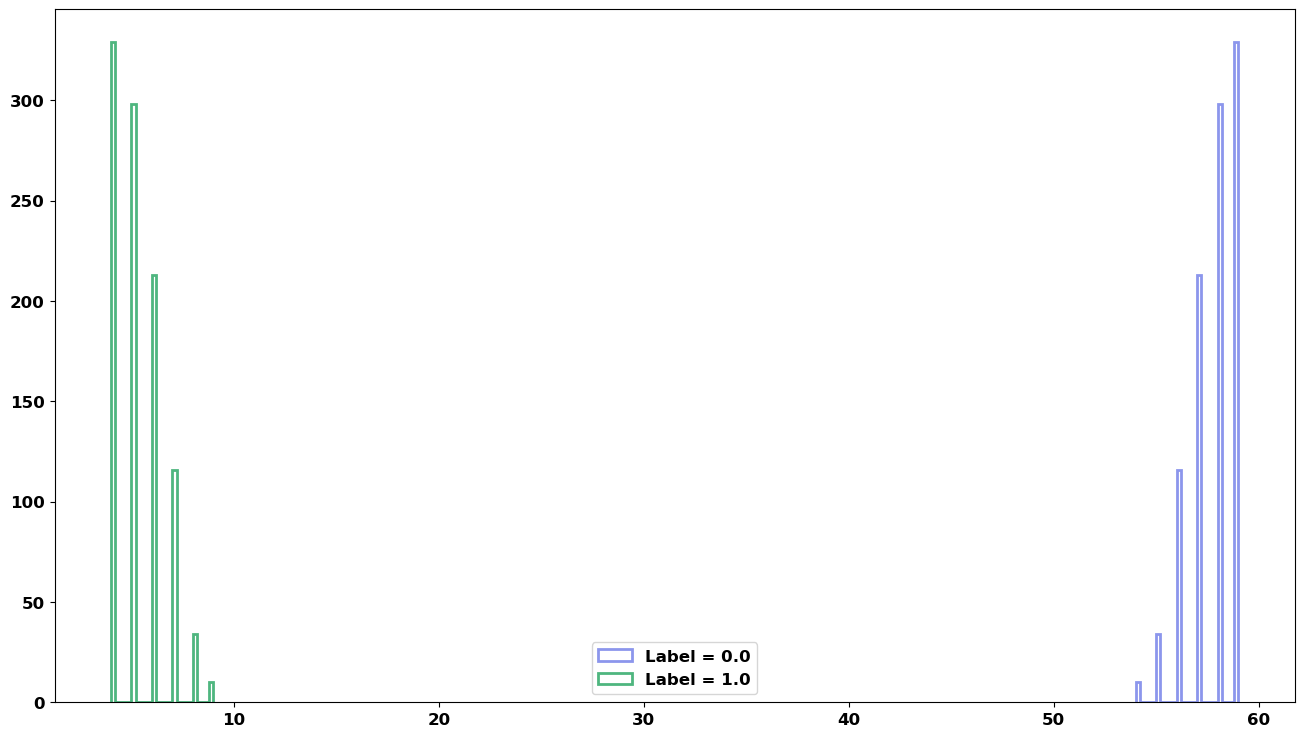

In [9]:
counters = [ Counter( labels[ "arr" ].loc[ split ] ) \
             for split in test_splits[ "arr" ] ]
counter_keys = np.unique( np.concatenate( [ list( counter.keys() ) \
                                            for counter in counters ] ) )
counter_summary = { counter_key: [ counter[ counter_key ] \
                                   for counter in counters ] \
                    for counter_key in counter_keys }
fig, sub_plot = plt.subplots( 1, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
counter_key_colors = [ "#8C96EC", "#4EB67F", "#E18163" ]
for i_key, ( counter_key, counts ) in enumerate( counter_summary.items() ):
    sub_plot.hist( counts, bins = 25, histtype = "step", \
                   color = counter_key_colors[ i_key ], linewidth = 2., \
                   label = "Label = {:}".format( counter_key ) )
sub_plot.legend( loc = "best" )

## Forward selection: Gd lesion _regression_

In [10]:
# Specify the configuration for this model.
gd_regr_model_config = { "model_type": "Poisson", "alpha": 1., "solver": "lbfgs", "warm_start": True, "fit_intercept": True, "tol": 1.e-4, "max_iter": 1000 }
# Specify the upper clip limit for Gd lesions.
gd_clip_lim = 5.
# Initialize arrays to hold the: models, predictions, and R^2 values for each bootstrap.
gd_regr_models, gd_regr_predictions, gd_regr_r2_vals = [], [], []
# Initialize lists for selected and remaining proteins.
gd_regr_selected_proteins, gd_regr_remaining_proteins = [], [ prot for prot in protein_columns ]
# Get ready to train all the models...
with tqdm( total = len( protein_columns ), \
            desc = "Forward selection for Poisson regression of lesion count" ) as pbar:
    # Keep going as long as we have proteins left.
    while len( gd_regr_remaining_proteins ) > 0:
        # Initialize this layer of the arrays.
        gd_regr_models.append( [] )
        gd_regr_predictions.append( [] )
        gd_regr_r2_vals.append( [] )
        # Iterate over the remaining proteins...
        for prot in gd_regr_remaining_proteins:
            gd_regr_models[ -1 ].append( [ train_model( create_model( model_type = gd_regr_model_config[ "model_type" ], config = gd_regr_model_config ), \
                                                        feature_data[ "gd" ].loc[ tr_spl ][ gd_regr_selected_proteins + [ prot ] ].values.astype( np.float64 ), \
                                                              labels[ "gd" ].loc[ tr_spl ].clip( 0., gd_clip_lim ).values.astype( np.float64 ), \
                                                        scaling = False )  \
                                           for tr_spl in train_splits[ "gd" ] ] )
            # ...isolate the non-nan rows in the data and the labels across the test splits.
            non_nan_rows = ( ( ~feature_data[ "gd" ][ gd_regr_selected_proteins + [ prot ] ].isna().any( axis = 1 ) ) & ( ~labels[ "gd" ].isna() ) )
            non_nan_rows = set( non_nan_rows[ non_nan_rows == True ].index )
            # Make predictions for each model trained on one of our training splits.
            gd_regr_predictions[ -1 ].append( [ pd.Series( model.predict( feature_data[ "gd" ].loc[ list( set( te_spl ).intersection( non_nan_rows ) ) ][ gd_regr_selected_proteins + \
                                                                                                                                                          [ prot ] ].values.astype( np.float64 ) ), \
                                                           index = list( set( te_spl ).intersection( non_nan_rows ) ) ) \
                                                for model, te_spl in zip( gd_regr_models[ -1 ][ -1 ], test_splits[ "gd" ] ) ] )
            # Calculate the R^2 score for these predictions over each split NOT the whole data set.
            gd_regr_r2_vals[ -1 ].append( [ linregress( predictions.clip( 0., gd_clip_lim ).values, \
                                                        labels[ "gd" ].loc[ predictions.index ].clip( 0., gd_clip_lim ).values ).rvalue ** 2. \
                                            if ( predictions.clip( 0., gd_clip_lim ).values.max() - predictions.clip( 0., gd_clip_lim ).values.min() ) > 0. else 0. \
                                            for predictions in gd_regr_predictions[ -1 ][ -1 ] ] )
        # Select the most performant next protein from this round...
        best_next_prot_ind = np.concatenate( [ np.array( r2vals ).reshape( 1, -1 ) \
                                                for r2vals in gd_regr_r2_vals[ -1 ] ], \
                                                axis = 0 ).mean( axis = 1 ).argmax()
        # ...add it to the list of picked proteins...
        gd_regr_selected_proteins.append( gd_regr_remaining_proteins[ best_next_prot_ind ] )
        # ...and drop it from lhe list of remaining ones.
        gd_regr_remaining_proteins.pop( best_next_prot_ind )
        # Update the status bar for this round.
        pbar.update( 1 )

Forward selection for Poisson regression of lesion count: 100%|██████████| 20/20 [09:40<00:00, 29.03s/it]


...a quick plot to check our results...

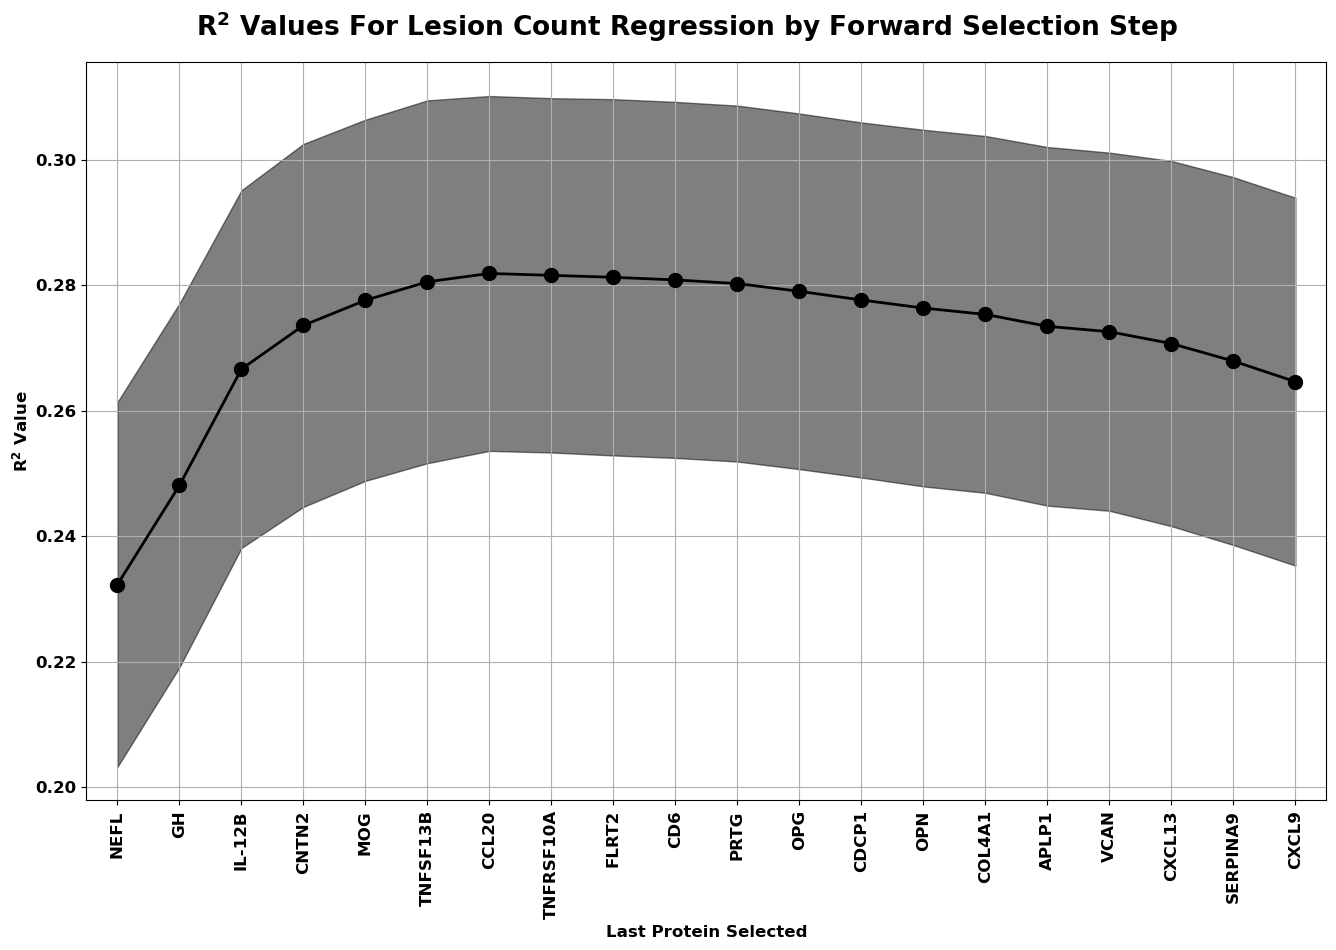

In [11]:
# Extract the mean and standard deviation over our train/test bootstraps.
bootstrap_stats = { "gd_regr": { "mean": np.array( [ np.concatenate( [ np.array( r2vals ).reshape( 1, -1 ) \
                                                                       for r2vals in r2_vals_for_this_round ], \
                                                                     axis = 0 ).mean( axis = 1 ).max() \
                                                     for r2_vals_for_this_round in gd_regr_r2_vals ] ), \
                                 "stdv": np.array( [ np.concatenate( [ np.array( r2vals ).reshape( 1, -1 ) \
                                                                       for r2vals in r2_vals_for_this_round ], \
                                                                     axis = 0 ).std( axis = 1 )[ np.concatenate( [ np.array( r2vals ).reshape( 1, -1 ) \
                                                                                                                   for r2vals in r2_vals_for_this_round ], \
                                                                                                                 axis = 0 ).mean( axis = 1 ).argmax() ] \
                                                     for r2_vals_for_this_round in gd_regr_r2_vals ] ) } }
# Create the figure.
fig, sub_plot = plt.subplots( 1, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
# Plot the mean R^2 values.
sub_plot.plot( np.arange( len( gd_regr_selected_proteins ) ), bootstrap_stats[ "gd_regr" ][ "mean" ], \
               "-o", color = "black", markersize = 10., linewidth = 2. )
# Add the standard deviation as a band around the mean.
sub_plot.fill_between( np.arange( len( gd_regr_selected_proteins ) ), \
                       bootstrap_stats[ "gd_regr" ][ "mean" ] - ( 0.5 * bootstrap_stats[ "gd_regr" ][ "stdv" ] ), \
                       bootstrap_stats[ "gd_regr" ][ "mean" ] + ( 0.5 * bootstrap_stats[ "gd_regr" ][ "stdv" ] ), \
                       color = "black", alpha = 0.5 )
# Formatting.
fig.suptitle( "R$^{2}$ Values For Lesion Count Regression by Forward Selection Step", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.1, hspace = 0.5, top = 0.93 )
sub_plot.set_xlim( [ -0.5, len( gd_regr_selected_proteins ) - 0.5 ] )
sub_plot.set_xticks( np.arange( len( gd_regr_selected_proteins ) ) )
sub_plot.set_xticklabels( [ prot.upper() for prot in gd_regr_selected_proteins ], rotation = 90. )
sub_plot.set_xlabel( "Last Protein Selected", fontdict = fig_font )
sub_plot.set_ylabel( "R$^{2}$ Value", fontdict = fig_font )
sub_plot.grid( True )

## Forward selection: Gd lesion _classification_

In [12]:
# Specify the configuration for this model (configuration from Fatima's work).
gd_clas_model_config = { "model_type": "LogRegr", "dual": False, "fit_intercept": True, "model_type": "logregr", "max_iter": 500, "n_jobs": -1, "class_weight": None, "solver": "saga", "penalty": "elasticnet", "C": 0.1, "tol": 0.005,  "l1_ratio": 0.1 }
# Initialize arrays to hold the: models, predictions, and R^2 values for each bootstrap.
gd_clas_models, gd_clas_predictions, gd_clas_auroc_vals = [], [], []
# Initialize lists for selected and remaining proteins.
gd_clas_selected_proteins, gd_clas_remaining_proteins = [], [ prot for prot in protein_columns ]
# Get ready to train all the models...
with tqdm( total = len( protein_columns ), \
            desc = "Forward selection for logistic regression prediction of Gd lesion presence" ) as pbar:
    # Keep going as long as we have proteins left.
    while len( gd_clas_remaining_proteins ) > 0:
        # Initialize this layer of the arrays.
        gd_clas_models.append( [] )
        gd_clas_predictions.append( [] )
        gd_clas_auroc_vals.append( [] )
        # Iterate over the remaining proteins...
        for prot in gd_clas_remaining_proteins:
            gd_clas_models[ -1 ].append( [ train_model( create_model( model_type = gd_clas_model_config[ "model_type" ], config = gd_clas_model_config ), \
                                                        feature_data[ "gd" ].loc[ tr_spl ][ gd_clas_selected_proteins + [ prot ] ].values.astype( np.float64 ), \
                                                              labels[ "gd" ].loc[ tr_spl ].clip( 0., 1. ).values.astype( np.float64 ), \
                                                        scaling = False )  \
                                           for tr_spl in train_splits[ "gd" ] ] )
            # ...isolate the non-nan rows in the data and the labels across the test splits.
            non_nan_rows = ( ( ~feature_data[ "gd" ][ gd_clas_selected_proteins + [ prot ] ].isna().any( axis = 1 ) ) & ( ~labels[ "gd" ].isna() ) )
            non_nan_rows = set( non_nan_rows[ non_nan_rows == True ].index )
            # Make predictions for each model trained on one of our training splits.
            gd_clas_predictions[ -1 ].append( [ pd.Series( model.predict_proba( feature_data[ "gd" ].loc[ list( set( te_spl ).intersection( non_nan_rows ) ) ][ gd_clas_selected_proteins + \
                                                                                                                                                                [ prot ] ].values.astype( np.float64 ) )[ :, 1 ], \
                                                           index = list( set( te_spl ).intersection( non_nan_rows ) ) ) \
                                                for model, te_spl in zip( gd_clas_models[ -1 ][ -1 ], test_splits[ "gd" ] ) ] )
            # Calculate the AUROC score for these predictions over each split NOT the whole data set.
            gd_clas_auroc_vals[ -1 ].append( [ roc_auc_score( labels[ "gd" ].loc[ predictions.index ].clip( 0., 1. ).values, \
                                                              predictions.values ) \
                                               for predictions in gd_clas_predictions[ -1 ][ -1 ] ] )
        # Select the most performant next protein from this round...
        best_next_prot_ind = np.concatenate( [ np.array( r2vals ).reshape( 1, -1 ) \
                                                for r2vals in gd_clas_auroc_vals[ -1 ] ], \
                                                axis = 0 ).mean( axis = 1 ).argmax()
        # ...add it to the list of picked proteins...
        gd_clas_selected_proteins.append( gd_clas_remaining_proteins[ best_next_prot_ind ] )
        # ...and drop it from lhe list of remaining ones.
        gd_clas_remaining_proteins.pop( best_next_prot_ind )
        # Update the status bar for this round.
        pbar.update( 1 )

Forward selection for logistic regression prediction of Gd lesion presence: 100%|██████████| 20/20 [26:22<00:00, 79.14s/it] 


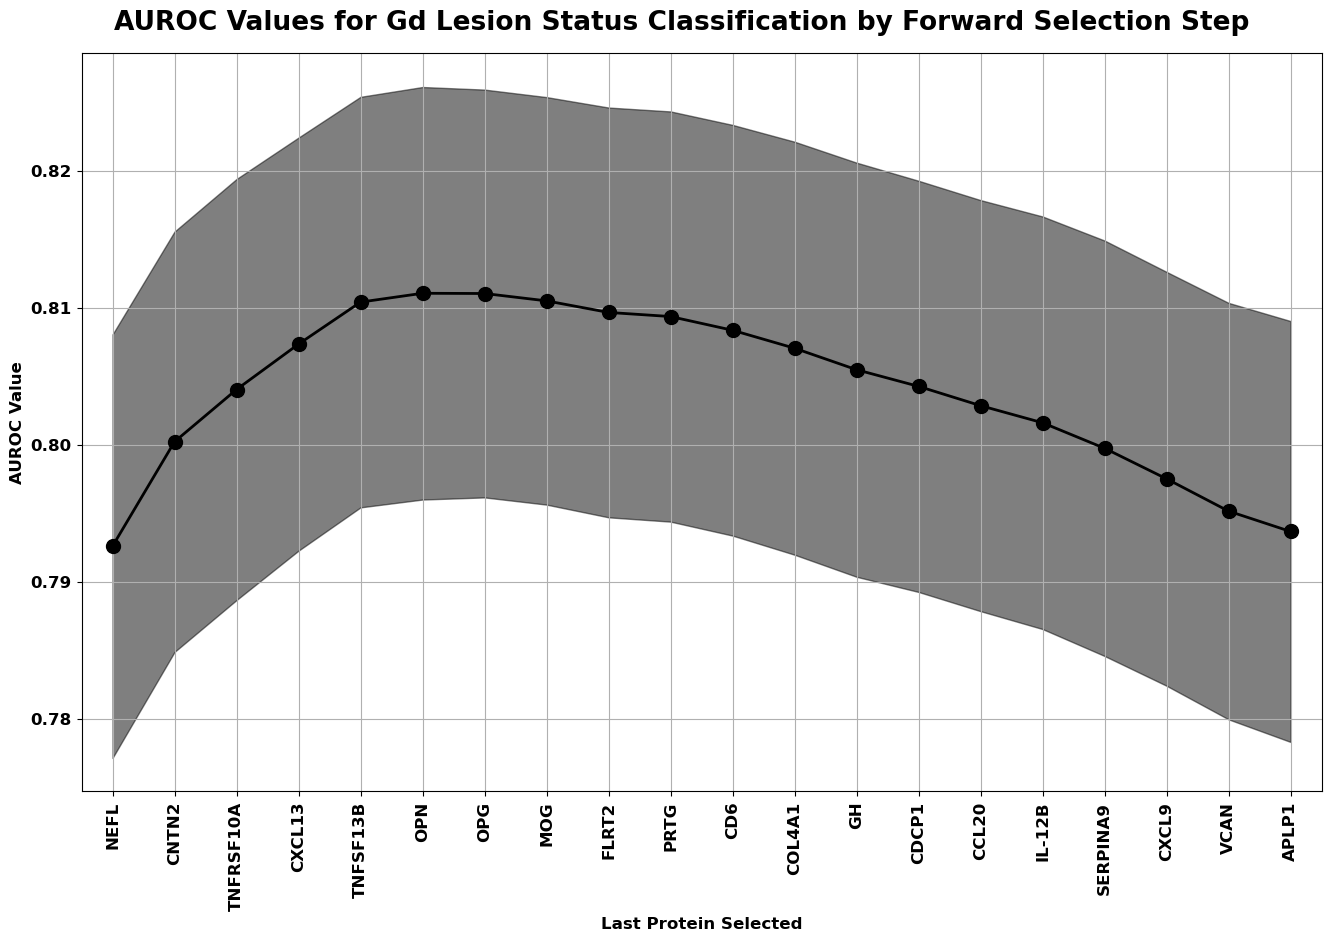

In [13]:
# Extract the mean and standard deviation over our train/test bootstraps.
bootstrap_stats[ "gd_clas" ] = { "mean": np.array( [ np.concatenate( [ np.array( aurocvals ).reshape( 1, -1 ) \
                                                                       for aurocvals in auroc_vals_for_this_round ], \
                                                                     axis = 0 ).mean( axis = 1 ).max() \
                                                     for auroc_vals_for_this_round in gd_clas_auroc_vals ] ), \
                                 "stdv": np.array( [ np.concatenate( [ np.array( aurocvals ).reshape( 1, -1 ) \
                                                                       for aurocvals in auroc_vals_for_this_round ], \
                                                                     axis = 0 ).std( axis = 1 )[ np.concatenate( [ np.array( aurocvals ).reshape( 1, -1 ) \
                                                                                                                   for aurocvals in auroc_vals_for_this_round ], \
                                                                                                                 axis = 0 ).mean( axis = 1 ).argmax() ] \
                                                     for auroc_vals_for_this_round in gd_clas_auroc_vals ] ) }
# Create the figure.
fig, sub_plot = plt.subplots( 1, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
# Plot the mean AUROC values.
sub_plot.plot( np.arange( len( gd_clas_selected_proteins ) ), bootstrap_stats[ "gd_clas" ][ "mean" ], \
               "-o", color = "black", markersize = 10., linewidth = 2. )
# Add the standard deviation as a band around the mean.
sub_plot.fill_between( np.arange( len( gd_clas_selected_proteins ) ), \
                       bootstrap_stats[ "gd_clas" ][ "mean" ] - ( 0.5 * bootstrap_stats[ "gd_clas" ][ "stdv" ] ), \
                       bootstrap_stats[ "gd_clas" ][ "mean" ] + ( 0.5 * bootstrap_stats[ "gd_clas" ][ "stdv" ] ), \
                       color = "black", alpha = 0.5 )
# Formatting.
fig.suptitle( "AUROC Values for Gd Lesion Status Classification by Forward Selection Step", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.1, hspace = 0.5, top = 0.93 )
sub_plot.set_xlim( [ -0.5, len( gd_clas_selected_proteins ) - 0.5 ] )
sub_plot.set_xticks( np.arange( len( gd_clas_selected_proteins ) ) )
sub_plot.set_xticklabels( [ prot.upper() for prot in gd_clas_selected_proteins ], rotation = 90. )
sub_plot.set_xlabel( "Last Protein Selected", fontdict = fig_font )
sub_plot.set_ylabel( "AUROC Value", fontdict = fig_font )
sub_plot.grid( True )

## Clinical relapse status (CRS) classification

In [14]:
# Specify the configuration for this model (configuration from Fatima's work).
crs_clas_model_config = { "model_type": "LogRegr", "dual": False, "fit_intercept": True, "multi_class": "auto", "max_iter": 500, "n_jobs": -1, "class_weight": None, "solver": "saga", "penalty": "elasticnet", "C": 0.1, "tol": 0.005,  "l1_ratio": 0.1 }
# Initialize arrays to hold the: models, predictions, and R^2 values for each bootstrap.
crs_clas_models, crs_clas_predictions, crs_clas_auroc_vals = [], [], []
# Initialize lists for selected and remaining proteins.
crs_clas_selected_proteins, crs_clas_remaining_proteins = [], [ prot for prot in protein_columns ]
# Get ready to train all the models...
with tqdm( total = len( protein_columns ), \
            desc = "Forward selection for logistic regression prediction of CRS classification" ) as pbar:
    # Keep going as long as we have proteins left.
    while len( crs_clas_remaining_proteins ) > 0:
        # Initialize this layer of the arrays.
        crs_clas_models.append( [] )
        crs_clas_predictions.append( [] )
        crs_clas_auroc_vals.append( [] )
        # Iterate over the remaining proteins...
        for prot in crs_clas_remaining_proteins:
            crs_clas_models[ -1 ].append( [ train_model( create_model( model_type = crs_clas_model_config[ "model_type" ], config = crs_clas_model_config ), \
                                                         feature_data[ "crs" ].loc[ tr_spl ][ crs_clas_selected_proteins + [ prot ] ].values.astype( np.float64 ), \
                                                               labels[ "crs" ].loc[ tr_spl ].values.astype( np.float64 ), \
                                                         scaling = False )  \
                                            for tr_spl in train_splits[ "crs" ] ] )
            # ...isolate the non-nan rows in the data and the labels across the test splits.
            non_nan_rows = ( ( ~feature_data[ "crs" ][ crs_clas_selected_proteins + [ prot ] ].isna().any( axis = 1 ) ) & ( ~labels[ "crs" ].isna() ) )
            non_nan_rows = set( non_nan_rows[ non_nan_rows == True ].index )
            # Make predictions for each model trained on one of our training splits.
            crs_clas_predictions[ -1 ].append( [ pd.Series( model.predict_proba( feature_data[ "crs" ].loc[ list( set( te_spl ).intersection( non_nan_rows ) ) ][ crs_clas_selected_proteins + \
                                                                                                                                                                  [ prot ] ].values.astype( np.float64 ) )[ :, 1 ], \
                                                            index = list( set( te_spl ).intersection( non_nan_rows ) ) ) \
                                                 for model, te_spl in zip( crs_clas_models[ -1 ][ -1 ], test_splits[ "crs" ] ) ] )
            # Calculate the AUROC score for these predictions over each split NOT the whole data set.
            crs_clas_auroc_vals[ -1 ].append( [ roc_auc_score( labels[ "crs" ].loc[ predictions.index ].values, \
                                                               predictions.values ) \
                                                for predictions in crs_clas_predictions[ -1 ][ -1 ] ] )
        # Select the most performant next protein from this round...
        best_next_prot_ind = np.concatenate( [ np.array( r2vals ).reshape( 1, -1 ) \
                                               for r2vals in crs_clas_auroc_vals[ -1 ] ], \
                                             axis = 0 ).mean( axis = 1 ).argmax()
        # ...add it to the list of picked proteins...
        crs_clas_selected_proteins.append( crs_clas_remaining_proteins[ best_next_prot_ind ] )
        # ...and drop it from lhe list of remaining ones.
        crs_clas_remaining_proteins.pop( best_next_prot_ind )
        # Update the status bar for this round.
        pbar.update( 1 )

Forward selection for logistic regression prediction of CRS classification: 100%|██████████| 20/20 [08:37<00:00, 25.89s/it]


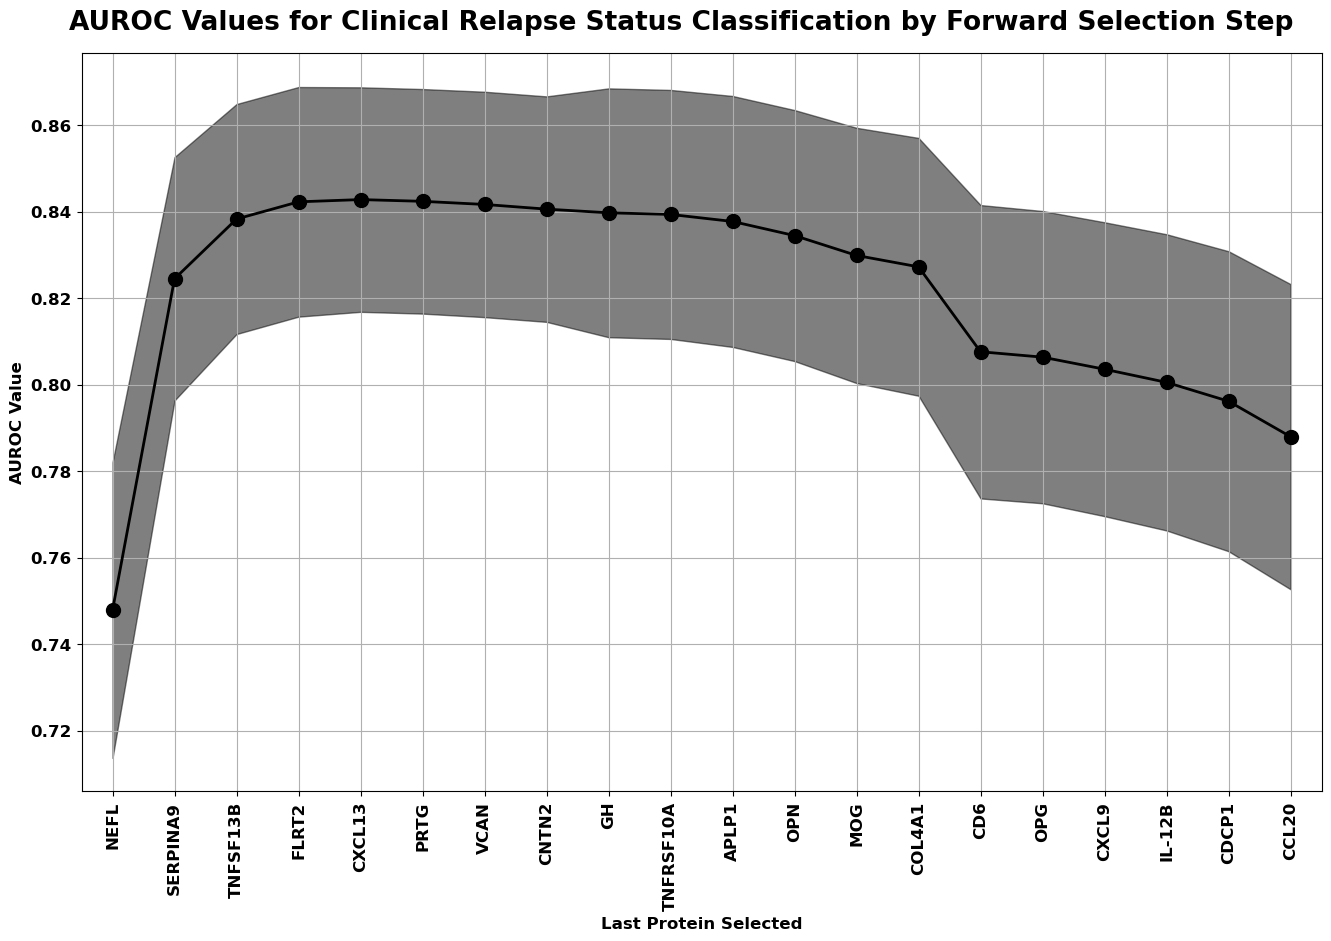

In [15]:
# Extract the mean and standard deviation over our train/test bootstraps.
bootstrap_stats[ "crs_clas" ] = { "mean": np.array( [ np.concatenate( [ np.array( aurocvals ).reshape( 1, -1 ) \
                                                                        for aurocvals in auroc_vals_for_this_round ], \
                                                                      axis = 0 ).mean( axis = 1 ).max() \
                                                      for auroc_vals_for_this_round in crs_clas_auroc_vals ] ), \
                                 "stdv": np.array( [ np.concatenate( [ np.array( aurocvals ).reshape( 1, -1 ) \
                                                                       for aurocvals in auroc_vals_for_this_round ], \
                                                                     axis = 0 ).std( axis = 1 )[ np.concatenate( [ np.array( aurocvals ).reshape( 1, -1 ) \
                                                                                                                   for aurocvals in auroc_vals_for_this_round ], \
                                                                                                                 axis = 0 ).mean( axis = 1 ).argmax() ] \
                                                     for auroc_vals_for_this_round in crs_clas_auroc_vals ] ) }
# Create the figure.
fig, sub_plot = plt.subplots( 1, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
# Plot the mean AUROC values.
sub_plot.plot( np.arange( len( crs_clas_selected_proteins ) ), bootstrap_stats[ "crs_clas" ][ "mean" ], \
               "-o", color = "black", markersize = 10., linewidth = 2. )
# Add the standard deviation as a band around the mean.
sub_plot.fill_between( np.arange( len( crs_clas_selected_proteins ) ), \
                       bootstrap_stats[ "crs_clas" ][ "mean" ] - ( 0.5 * bootstrap_stats[ "crs_clas" ][ "stdv" ] ), \
                       bootstrap_stats[ "crs_clas" ][ "mean" ] + ( 0.5 * bootstrap_stats[ "crs_clas" ][ "stdv" ] ), \
                       color = "black", alpha = 0.5 )
# Formatting.
fig.suptitle( "AUROC Values for Clinical Relapse Status Classification by Forward Selection Step", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.1, hspace = 0.5, top = 0.93 )
sub_plot.set_xlim( [ -0.5, len( crs_clas_selected_proteins ) - 0.5 ] )
sub_plot.set_xticks( np.arange( len( crs_clas_selected_proteins ) ) )
sub_plot.set_xticklabels( [ prot.upper() for prot in crs_clas_selected_proteins ], rotation = 90. )
sub_plot.set_xlabel( "Last Protein Selected", fontdict = fig_font )
sub_plot.set_ylabel( "AUROC Value", fontdict = fig_font )
sub_plot.grid( True )

## Annualized relapse rate (ARR) classification

In [16]:
# Specify the configuration for this model (configuration from Fatima's work).
arr_clas_model_config = { "model_type": "LogRegr", "dual": False, "fit_intercept": True, "max_iter": 500, "n_jobs": -1, "class_weight": None, "solver": "saga", "penalty": "elasticnet", "C": 0.2, "tol": 0.0005,  "l1_ratio": 0.1 }
# Initialize arrays to hold the: models, predictions, and R^2 values for each bootstrap.
arr_clas_models, arr_clas_predictions, arr_clas_auroc_vals = [], [], []
# Initialize lists for selected and remaining proteins.
arr_clas_selected_proteins, arr_clas_remaining_proteins = [], [ prot for prot in protein_columns ]
# Get ready to train all the models...
with tqdm( total = len( protein_columns ), \
            desc = "Forward selection for logistic regression prediction of ARR classification" ) as pbar:
    # Keep going as long as we have proteins left.
    while len( arr_clas_remaining_proteins ) > 0:
        # Initialize this layer of the arrays.
        arr_clas_models.append( [] )
        arr_clas_predictions.append( [] )
        arr_clas_auroc_vals.append( [] )
        # Iterate over the remaining proteins...
        for prot in arr_clas_remaining_proteins:
            arr_clas_models[ -1 ].append( [ train_model( create_model( model_type = arr_clas_model_config[ "model_type" ], config = arr_clas_model_config ), \
                                                         feature_data[ "arr" ].loc[ tr_spl ][ arr_clas_selected_proteins + [ prot ] ].values.astype( np.float64 ), \
                                                               labels[ "arr" ].loc[ tr_spl ].values.astype( np.float64 ), \
                                                         scaling = False )  \
                                            for tr_spl in train_splits[ "arr" ] ] )
            # ...isolate the non-nan rows in the data and the labels across the test splits.
            non_nan_rows = ( ( ~feature_data[ "arr" ][ arr_clas_selected_proteins + [ prot ] ].isna().any( axis = 1 ) ) & ( ~labels[ "arr" ].isna() ) )
            non_nan_rows = set( non_nan_rows[ non_nan_rows == True ].index )
            # Make predictions for each model trained on one of our training splits.
            arr_clas_predictions[ -1 ].append( [ pd.Series( model.predict_proba( feature_data[ "arr" ].loc[ list( set( te_spl ).intersection( non_nan_rows ) ) ][ arr_clas_selected_proteins + \
                                                                                                                                                                  [ prot ] ].values.astype( np.float64 ) )[ :, 1 ], \
                                                            index = list( set( te_spl ).intersection( non_nan_rows ) ) ) \
                                                 for model, te_spl in zip( arr_clas_models[ -1 ][ -1 ], test_splits[ "arr" ] ) ] )
            # Calculate the AUROC score for these predictions over each split NOT the whole data set.
            arr_clas_auroc_vals[ -1 ].append( [ roc_auc_score( labels[ "arr" ].loc[ predictions.index ].values, \
                                                               predictions.values ) \
                                                for predictions in arr_clas_predictions[ -1 ][ -1 ] ] )
        # Select the most performant next protein from this round...
        best_next_prot_ind = np.concatenate( [ np.array( r2vals ).reshape( 1, -1 ) \
                                               for r2vals in arr_clas_auroc_vals[ -1 ] ], \
                                             axis = 0 ).mean( axis = 1 ).argmax()
        # ...add it to the list of picked proteins...
        arr_clas_selected_proteins.append( arr_clas_remaining_proteins[ best_next_prot_ind ] )
        # ...and drop it from lhe list of remaining ones.
        arr_clas_remaining_proteins.pop( best_next_prot_ind )
        # Update the status bar for this round.
        pbar.update( 1 )

Forward selection for logistic regression prediction of ARR classification: 100%|██████████| 20/20 [09:33<00:00, 28.66s/it]


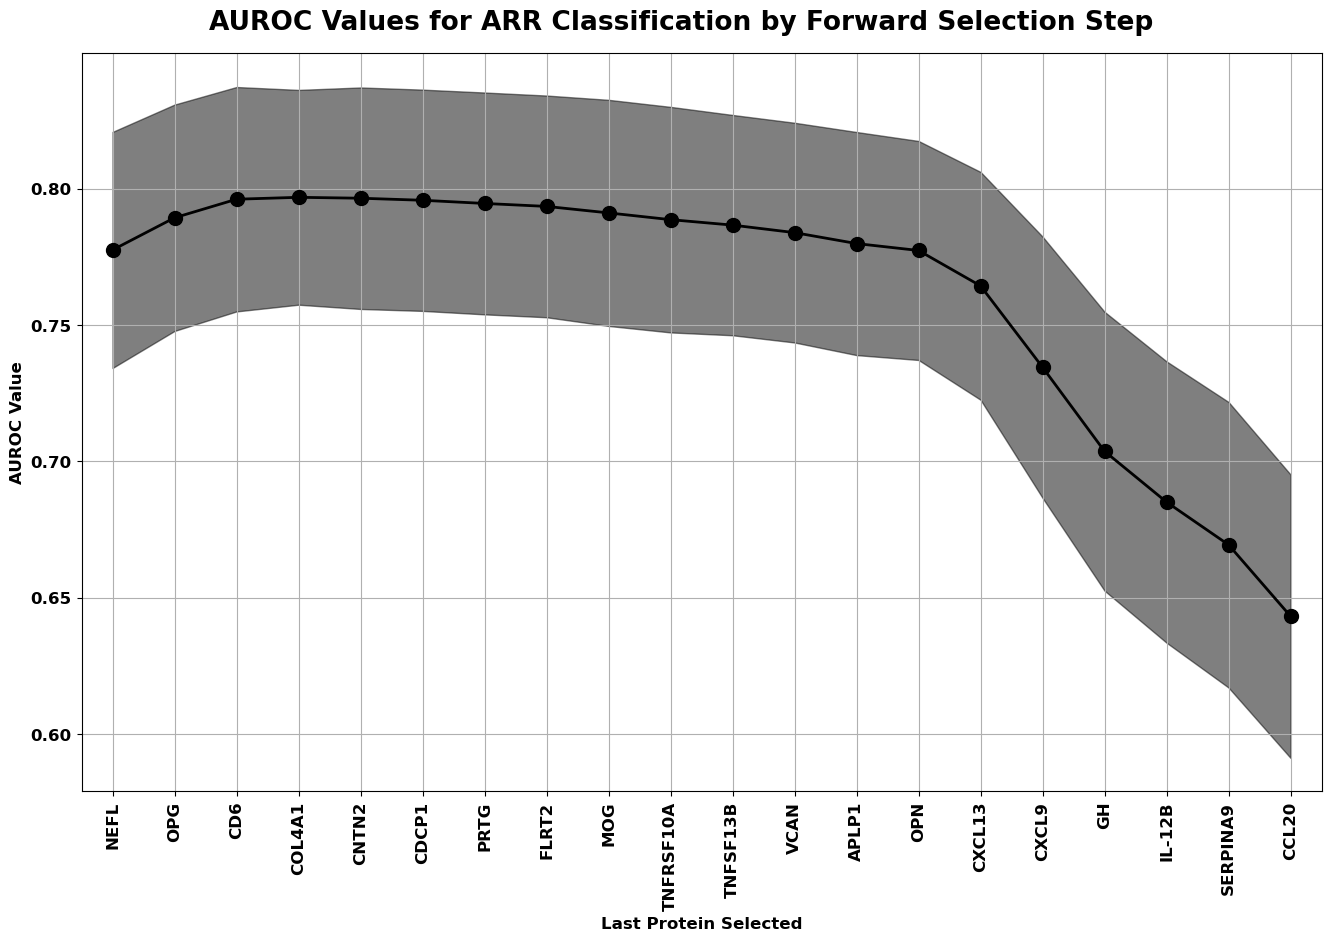

In [17]:
# Extract the mean and standard deviation over our train/test bootstraps.
bootstrap_stats[ "arr_clas" ] = { "mean": np.array( [ np.concatenate( [ np.array( aurocvals ).reshape( 1, -1 ) \
                                                                        for aurocvals in auroc_vals_for_this_round ], \
                                                                      axis = 0 ).mean( axis = 1 ).max() \
                                                      for auroc_vals_for_this_round in arr_clas_auroc_vals ] ), \
                                 "stdv": np.array( [ np.concatenate( [ np.array( aurocvals ).reshape( 1, -1 ) \
                                                                       for aurocvals in auroc_vals_for_this_round ], \
                                                                     axis = 0 ).std( axis = 1 )[ np.concatenate( [ np.array( aurocvals ).reshape( 1, -1 ) \
                                                                                                                   for aurocvals in auroc_vals_for_this_round ], \
                                                                                                                 axis = 0 ).mean( axis = 1 ).argmax() ] \
                                                     for auroc_vals_for_this_round in arr_clas_auroc_vals ] ) }
# Create the figure.
fig, sub_plot = plt.subplots( 1, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
# Plot the mean AUROC values.
sub_plot.plot( np.arange( len( arr_clas_selected_proteins ) ), bootstrap_stats[ "arr_clas" ][ "mean" ], \
               "-o", color = "black", markersize = 10., linewidth = 2. )
# Add the standard deviation as a band around the mean.
sub_plot.fill_between( np.arange( len( arr_clas_selected_proteins ) ), \
                       bootstrap_stats[ "arr_clas" ][ "mean" ] - ( 0.5 * bootstrap_stats[ "arr_clas" ][ "stdv" ] ), \
                       bootstrap_stats[ "arr_clas" ][ "mean" ] + ( 0.5 * bootstrap_stats[ "arr_clas" ][ "stdv" ] ), \
                       color = "black", alpha = 0.5 )
# Formatting.
fig.suptitle( "AUROC Values for ARR Classification by Forward Selection Step", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.1, hspace = 0.5, top = 0.93 )
sub_plot.set_xlim( [ -0.5, len( arr_clas_selected_proteins ) - 0.5 ] )
sub_plot.set_xticks( np.arange( len( arr_clas_selected_proteins ) ) )
sub_plot.set_xticklabels( [ prot.upper() for prot in arr_clas_selected_proteins ], rotation = 90. )
sub_plot.set_xlabel( "Last Protein Selected", fontdict = fig_font )
sub_plot.set_ylabel( "AUROC Value", fontdict = fig_font )
sub_plot.grid( True )

## Summary plot of all forward selection results.
We need to combine these into a single figure for the paper. Let's do that now.

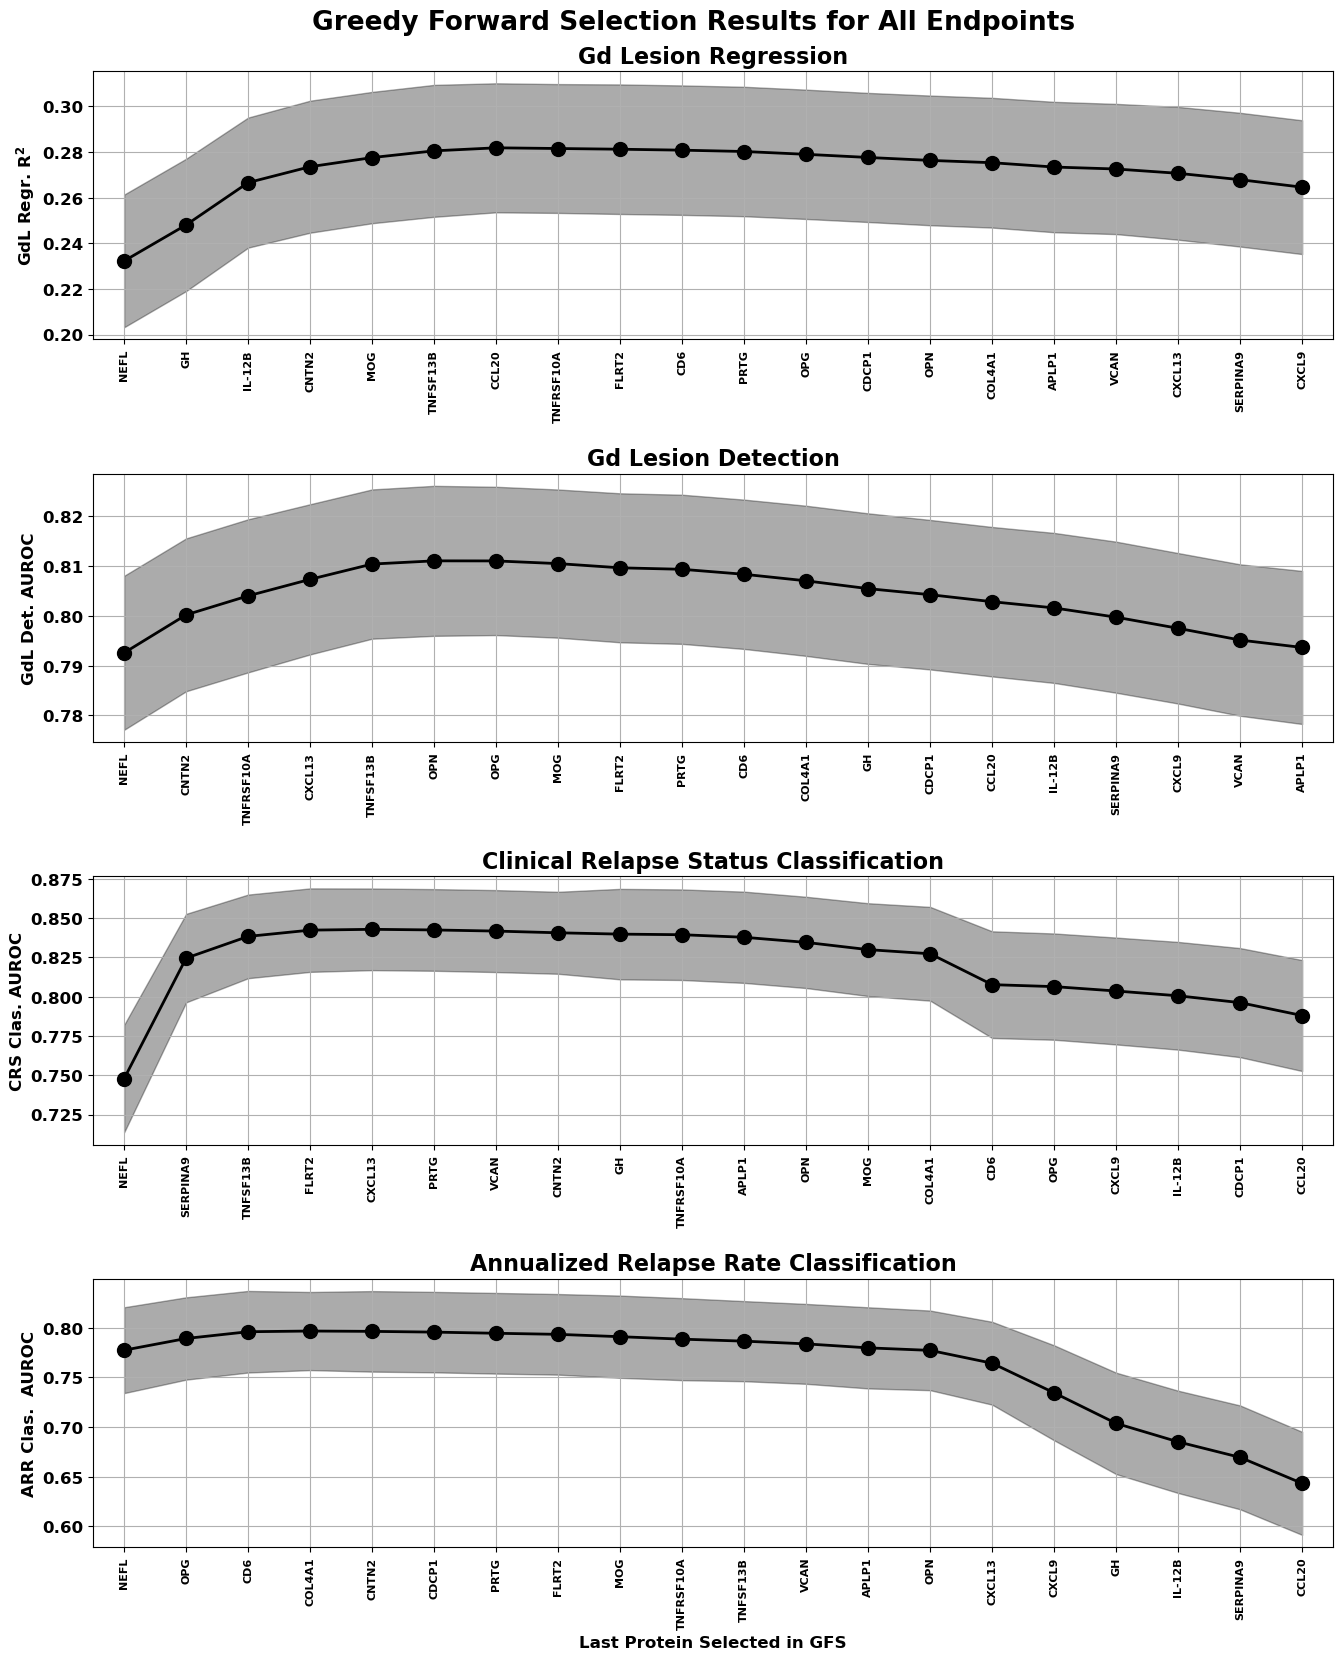

In [18]:
# Create the figure.
fig, sub_plot = plt.subplots( len( bootstrap_stats ), 1, figsize = ( 16., 18. ), facecolor = "white", edgecolor = "white" )
# Iterate over the four GFS analyses (and the subplots...).
for analysis, sp in zip( bootstrap_stats.keys(), sub_plot ):
    # Plot the mean AUROC values.
    sp.plot( np.arange( len( protein_columns ) ), bootstrap_stats[ analysis ][ "mean" ], \
             "-o", color = "black", markersize = 10., linewidth = 2. )
    # Add the standard deviation as a band around the mean.
    sp.fill_between( np.arange( len( arr_clas_selected_proteins ) ), \
                     bootstrap_stats[ analysis ][ "mean" ] - ( 0.5 * bootstrap_stats[ analysis ][ "stdv" ] ), \
                     bootstrap_stats[ analysis ][ "mean" ] + ( 0.5 * bootstrap_stats[ analysis ][ "stdv" ] ), \
                     color = "black", alpha = 0.33 )
# Formatting.
fig.suptitle( "Greedy Forward Selection Results for All Endpoints", \
              x = 0.5, y = 0.95, ha = "center", va = "bottom", \
              fontsize = title_font[ "size" ] + 3, fontweight = title_font[ "weight" ] )
plt.subplots_adjust( wspace = 0.1, hspace = 0.5, top = 0.93 )
display_names = { "gd_regr": { "plot_title": "Gd Lesion Regression",                   "axis_title": "GdL Regr. R$^{2}$" }, \
                  "gd_clas": { "plot_title": "Gd Lesion Detection",                    "axis_title": "GdL Det. AUROC"    }, \
                 "crs_clas": { "plot_title": "Clinical Relapse Status Classification", "axis_title": "CRS Clas. AUROC"   }, \
                 "arr_clas": { "plot_title": "Annualized Relapse Rate Classification", "axis_title": "ARR Clas.  AUROC"  } }
for analysis, sp, sel_prot in zip( bootstrap_stats.keys(), sub_plot, [ gd_regr_selected_proteins, \
                                                                       gd_clas_selected_proteins, \
                                                                       crs_clas_selected_proteins, \
                                                                       arr_clas_selected_proteins ] ):
    sp.set_title( display_names[ analysis ][ "plot_title" ], fontdict = title_font )
    sp.set_xlim( [ -0.5, len( sel_prot ) - 0.5 ] )
    sp.set_xticks( np.arange( len( sel_prot ) ) )
    sp.set_xticklabels( [ prot.upper() for prot in sel_prot ], rotation = 90., fontdict = small_font )
    if sp == sub_plot[ -1 ]:
        sp.set_xlabel( "Last Protein Selected in GFS", fontdict = fig_font )
    sp.set_ylabel( display_names[ analysis ][ "axis_title" ], fontdict = fig_font )
    sp.grid( True )
plt.savefig( "./latex/figures/fwd_sel_all_endopints.pdf", dpi = 300., bbox_inches = "tight" )
plt.savefig( "./latex/figures/fwd_sel_all_endopints.png", dpi = 300., bbox_inches = "tight" )

In [19]:
selected_proteins = { "gd_regr": gd_regr_selected_proteins, \
                      "gd_clas": gd_clas_selected_proteins, \
                     "crs_clas": crs_clas_selected_proteins, \
                     "arr_clas": arr_clas_selected_proteins }
summary_table = pd.DataFrame( { analysis: [ "{:} ({:1.3f} +/- {:1.3f})".format( sel_prot.upper(), mean_val, 0.5 * stdv_val ) \
                                            for sel_prot, mean_val, stdv_val in zip( selected_proteins[ analysis ], \
                                                                                       bootstrap_stats[ analysis ][ "mean" ], \
                                                                                       bootstrap_stats[ analysis ][ "stdv" ] ) ] \
                                for analysis in bootstrap_stats.keys() }, \
                              index = np.arange( len( protein_columns ) ) + 1 )
summary_table.to_csv( "gfs_summary.csv" )
summary_table

,gd_regr,gd_clas,crs_clas,arr_clas
1,NEFL (0.232 +/- 0.029),NEFL (0.793 +/- 0.015),NEFL (0.748 +/- 0.034),NEFL (0.778 +/- 0.043)
2,GH (0.248 +/- 0.029),CNTN2 (0.800 +/- 0.015),SERPINA9 (0.824 +/- 0.028),OPG (0.789 +/- 0.041)
3,IL-12B (0.267 +/- 0.029),TNFRSF10A (0.804 +/- 0.015),TNFSF13B (0.838 +/- 0.027),CD6 (0.796 +/- 0.041)
4,CNTN2 (0.274 +/- 0.029),CXCL13 (0.807 +/- 0.015),FLRT2 (0.842 +/- 0.027),COL4A1 (0.797 +/- 0.039)
5,MOG (0.278 +/- 0.029),TNFSF13B (0.810 +/- 0.015),CXCL13 (0.843 +/- 0.026),CNTN2 (0.796 +/- 0.041)
6,TNFSF13B (0.281 +/- 0.029),OPN (0.811 +/- 0.015),PRTG (0.842 +/- 0.026),CDCP1 (0.796 +/- 0.041)
7,CCL20 (0.282 +/- 0.028),OPG (0.811 +/- 0.015),VCAN (0.842 +/- 0.026),PRTG (0.795 +/- 0.041)
8,TNFRSF10A (0.282 +/- 0.028),MOG (0.811 +/- 0.015),CNTN2 (0.841 +/- 0.026),FLRT2 (0.793 +/- 0.041)
9,FLRT2 (0.281 +/- 0.028),FLRT2 (0.810 +/- 0.015),GH (0.840 +/- 0.029),MOG (0.791 +/- 0.041)
10,CD6 (0.281 +/- 0.028),PRTG (0.809 +/- 0.015),TNFRSF10A (0.839 +/- 0.029),TNFRSF10A (0.789 +/- 0.041)
